# Read SNOWPACK Output
This script will read in output from SNOWPACK, and also plot it with SUMup data. 

In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
import xarray as xr

# Set up plotting aesthetics
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 14
mpl.rcParams['mathtext.fontset'] = 'cm'
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

## Read in .pro files

In [2]:
# Function for reading in .pro file
def read_pro(pro):
    
    f = open(pro,'r')
    
    # Header is 47 lines
    for i in range(47):
        header = f.readline()
    
    # After header, read in rest of data
    data = f.readlines()
    
    # Create empty list for data
    data_all = list()
    
    # Read lines in data
    for line in data:
        # Date
        if line[0:4] == '0500':
            d = line.split(',')[1].split('.')
            timestamp = datetime.datetime(int(d[2][0:4]), int(d[1]), int(d[0]), int(d[2][5:7]))
            data_dict = {} # Create dictionary of data for each timestamp
            data_dict['Date'] = timestamp
        # Depth (m)
        elif line[0:4] == '0501':
            depth_dict = list(map(float, line.split('\n')[0].split(',')[2:]))
            depth_dict = np.asarray(depth_dict)/100 # Convert from cm to m
        # Density (kg/m^3)
        elif line[0:4] == '0502':
            density_dict = list(map(float, line.split('\n')[0].split(',')[2:]))
            density_dict = np.asarray(density_dict)
        # Snow temperature (K)
        elif line[0:4] == '0503': 
            temp_dict = list(map(float, line.split('\n')[0].split(',')[2:]))
            temp_dict = np.asarray(temp_dict)
        # Water content (%)
        elif line[0:4] == '0506':
            water_dict = list(map(float, line.split('\n')[0].split(',')[2:]))
            water_dict = np.asarray(water_dict)  
        # Ice content (%)
        elif line[0:4] == '0515':
            ice_dict = list(map(float, line.split('\n')[0].split(',')[2:]))
            ice_dict = np.asarray(ice_dict)
        # Air content (%)
        elif line[0:4] == '0516':
            air_dict = list(map(float, line.split('\n')[0].split(',')[2:]))
            air_dict = np.asarray(air_dict)
        
        # Create firn profiles
            data_dict['Depth'] = depth_dict[i:]
            data_dict['Density'] = density_dict[i:]
            data_dict['Tempearture'] = temp_dict[i:]
            data_dict['Air'] = air_dict[i:]/100
            data_dict['Water'] = water_dict[i:]/100
            data_dict['Ice'] = ice_dict[i:]/100
            data_dict['Density_total'] = density_dict
            data_dict['Depth_total'] = depth_dict
            
            data_all.append(data_dict)
        
    return data_all
    
    f.close()

In [8]:
# Read in files of interest
VIR154_4 = read_pro('VIR154_TEST4.pro')
VIR203_4 = read_pro('VIR203_TEST4.pro')
VIR154 = read_pro('VIR154_TEST.pro')
VIR203 = read_pro('VIR203_TEST.pro')

## Read in SUMup data

In [9]:
# Open dataset
sumup = xr.open_dataset('sumup_density_2020.nc')

# Extract data
su_citation = sumup['Citation'].values
su_date = sumup['Date'].values
su_lat = sumup['Latitude'].values
su_lon = sumup['Longitude'].values
su_depth0 = sumup['Start_Depth'].values
su_depth1 = sumup['Stop_Depth'].values
su_midpoint = sumup['Midpoint'].values
su_density = sumup['Density'].values

In [10]:
lat203 = []
lon203 = []
depth203 = []
dens203 = []

lat154 = []
lon154 = []
depth154 = []
dens154 = []
for i in range(len(su_citation)):
    if su_citation[i] == 140:
        lat203.append(su_lat[i])
        lon203.append(su_lon[i])
        depth203.append(su_midpoint[i])
        dens203.append(su_density[i]*1000)
    if su_date[i] == 20110114:
        lat154.append(su_lat[i])
        lon154.append(su_lon[i])
        depth154.append(su_midpoint[i])
        dens154.append(su_density[i]*1000)

data203 = {'Latidtude':lat203,'Longitude':lon203,'Depth':depth203,'Density':dens203}
df203 = pd.DataFrame(data203)

data154 = {'Latidtude':lat154,'Longitude':lon154,'Depth':depth154,'Density':dens154}
df154 = pd.DataFrame(data154)

## Plot SNOWPACK and SUMup data

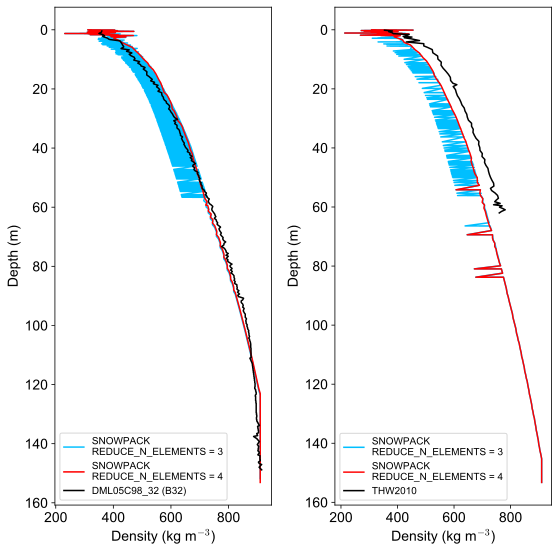

In [20]:
figure = plt.figure(figsize=(8,8))

# VIR203, DML
ax1 = figure.add_subplot(121)
ax1.set_ylabel('Depth (m)')
ax1.set_xlabel(r'Density (kg m$^{-3}$)')

ax1.plot(VIR203[400]['Density_total'],VIR203[400]['Depth_total'][-1]-VIR203[400]['Depth_total'],c='deepskyblue',label='SNOWPACK\nREDUCE_N_ELEMENTS = 3')
ax1.plot(VIR203_4[400]['Density_total'],VIR203_4[400]['Depth_total'][-1]-VIR203_4[400]['Depth_total'],c='r',label='SNOWPACK\nREDUCE_N_ELEMENTS = 4')
ax1.plot(df203.Density,df203.Depth,'k',label='DML05C98_32 (B32)')

ax1.invert_yaxis()
plt.legend(prop={"size":10})


# VIR154, THW
ax2 = figure.add_subplot(122)
ax2.set_ylabel('Depth (m)')
ax2.set_xlabel(r'Density (kg m$^{-3}$)')

ax2.plot(VIR154[400]['Density_total'],VIR154[400]['Depth_total'][-1]-VIR154[400]['Depth_total'],c='deepskyblue',label='SNOWPACK\nREDUCE_N_ELEMENTS = 3')
ax2.plot(VIR154_4[400]['Density_total'],VIR154_4[400]['Depth_total'][-1]-VIR154_4[400]['Depth_total'],c='r',label='SNOWPACK\nREDUCE_N_ELEMENTS = 4')
ax2.plot(df154.Density,df154.Depth,'k',label='THW2010')

ax2.invert_yaxis()
plt.legend(prop={"size":10})

plt.tight_layout()

# plt.savefig('/Users/metm9666/Desktop/SNOWPACK_SpinUp_Test.png')